# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [2]:
import os
import shutil
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output


import const as cst
from libs.pconv_model import PConvUnet
from libs.util import random_mask

os.environ["CUDA_VISIBLE_DEVICES"]="0"

BATCH_SIZE = 1

%load_ext autoreload
%autoreload 2
plt.ioff()

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Creating train & test data generator

In [4]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmented image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1
            
            print(ori.shape)
            print(mask.shape)
            

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

            
# # Create training generator
# train_datagen = DataGenerator(  
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     rescale=1./255,
#     horizontal_flip=True
# )
# train_generator = train_datagen.flow_from_directory(
#     cst.TRAIN_PATH, target_size=(256, 512), batch_size=BATCH_SIZE
# )

# # # Create validation generator
# val_datagen = DataGenerator(rescale=1./255)
# val_generator = val_datagen.flow_from_directory(
#     cst.VAL_PATH, target_size=(256, 512), batch_size=BATCH_SIZE, seed=1
# )

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    cst.TEST_PATH,
    target_size=(cst.MAX_HEIGHT, cst.MAX_WIDTH),
    batch_size=BATCH_SIZE,
    seed=1
)

# cst.MAX_HEIGHT, cst.MAX_WIDTH

# test_datagen = DataGenerator(
#                     rescale=1./255,
#                     random_crop_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH))
# test_generator = test_datagen.flow_from_directory(
#                     cst.TEST_PATH,
#                     target_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH),
#                     batch_size=BATCH_SIZE,
#                     seed=1)

Found 3 images belonging to 1 classes.
(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


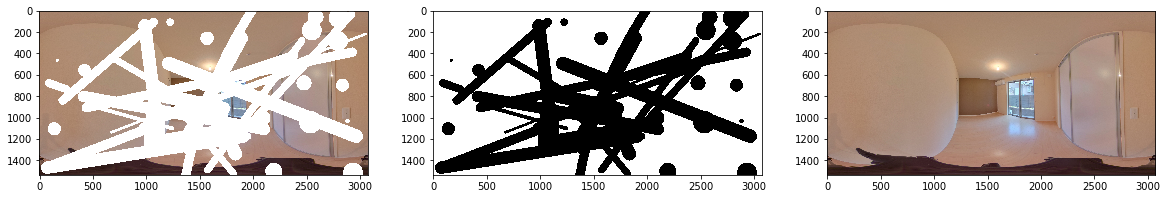

In [5]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

In [ ]:
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-crop-512-1024/1_weights_2018-10-27-05-22-52.h5',
    train_bn=False,
    lr=0.00005
)

In [10]:

for layer in model.layers:
    print(layer)

TypeError: 'method' object is not iterable

In [11]:
# import sys
# sys.setrecursionlimit(10000)

# model = PConvUnet(weight_filepath='data/logs/')

from libs.pconv_model import PConvUnet
from keras.layers.wrappers import Wrapper
from keras.layers import Dense, Dropout, Flatten, Input
from keras.models import Model

print(model.layers)
print(type(model.layers))

for layer in model.layers:
    weights = layer.get_weights()
    for weight in weights:
        print(weight.shape)
        if np.any(np.isnan(weight)):
            print(layer.name)
            print(weights)

            
#     print(layer.get_weights())

<bound method PConvUnet.layers of <libs.pconv_model.PConvUnet object at 0x7f2771d417b8>>
<class 'method'>


TypeError: 'method' object is not iterable

In [6]:
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-crop-256x512/2_weights_2018-10-31-15-21-59.h5',
    train_bn=False,
    lr=0.00005
)

(?, 1536, 3072, 3)
(?, 1536, 3072, 3)


In [7]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using PIL
from PIL import Image
import time
from datetime import datetime

# Create dir
start = time.time()
filename = datetime.now().strftime("%Y%m%d_%H%M")
print("Start: " + str(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

dir_name = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dir_path = '/mnt/PConv-Keras/output_sample/' + dir_name
os.makedirs(dir_path)

n = 0

for (masked, mask), ori in tqdm(test_generator):
    masked = cv2.resize(masked[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    mask = cv2.resize(mask[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    ori = cv2.resize(ori[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
            
    # Clear current output and display test images
    for i in range(len(ori)):
        mask_image = Image.fromarray(np.uint8(masked[i,:,:,:]*255))
        pred_image = Image.fromarray(np.uint8((pred_img[i,:,:,:]*1.*255)))
        ori_image  = Image.fromarray(np.uint8(ori[i,:,:,:]*255))
#         print(pred_img)
#         print(pred_img.mean())        
#         print(np.uint8((pred_img[i,:,:,:]*1.)*255))
                
        save_mask_path = '/mnt/PConv-Keras/output_sample/{}/{}_masked_img_{}.png'.format(dir_name, pred_time, i)
        save_pred_path = '/mnt/PConv-Keras/output_sample/{}/{}_predicted_img_{}.png'.format(dir_name, pred_time, i)
        save_ori_path  = '/mnt/PConv-Keras/output_sample/{}/{}_original_img_{}.png'.format(dir_name, pred_time, i)
        
        mask_image.save(save_mask_path)
        pred_image.save(save_pred_path)
        ori_image.save(save_ori_path)

        n += 1        
        
    # Only create predictions for about 100 images
    if n > 30:
        break
        
        
elapsed_time = time.time() - start            
print("Elapsed_time:{0}".format(elapsed_time) + "[sec]")        

0it [00:00, ?it/s]

Start: 2018-10-31 16:15:24
(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


1it [00:21, 21.03s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


2it [00:28, 16.99s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


3it [00:36, 14.17s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


4it [00:43, 12.25s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


5it [00:51, 10.92s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


6it [01:00, 10.17s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


7it [01:08,  9.51s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


8it [01:16,  9.10s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


9it [01:23,  8.51s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


10it [01:31,  8.32s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


11it [01:38,  8.10s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


12it [01:46,  7.86s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


13it [01:54,  7.87s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


14it [02:02,  8.01s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


15it [02:10,  8.02s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


16it [02:18,  7.91s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


17it [02:25,  7.89s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


18it [02:34,  8.04s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


19it [02:42,  7.98s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


20it [02:50,  7.93s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


21it [02:58,  8.00s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


22it [03:05,  7.94s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


23it [03:13,  7.88s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


24it [03:20,  7.67s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


25it [03:28,  7.56s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


26it [03:36,  7.69s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


27it [03:44,  7.76s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


28it [03:52,  7.92s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


29it [04:00,  7.83s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)


30it [04:07,  7.85s/it]

(1, 1536, 3072, 3)
(1, 1536, 3072, 3)
Elapsed_time:255.44927597045898[sec]


# Training on PIXNET Food 20. It's only for demo. Please use Command Line

In [ ]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig('{}/data/output_samples/img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [ ]:
# Instantiate the model
model = PConvUnet(weight_filepath='data/model/')
model.load("/mnt/PConv-Keras/data/model/3_weights_2018-09-23-17-22-33.h5")

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=100,
    epochs=50,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='../data/logs/initial_training', write_graph=False)
    ]
)

## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    '{}/data/model/weight-256-512/3000_weights_2018-10-07-05-52-50.h5'.format(cst.MNT_PATH),
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=3,
    validation_data=val_generator,
    validation_steps=100,
    epochs=1,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='../data', write_graph=False)
    ]
)

## Phase 3 - Generating samples

In [ ]:
# # Load weights from previous run
print(cst.MAX_HEIGHT)
print(cst.MAX_WIDTH)

model = PConvUnet(
    img_rows=cst.MAX_HEIGHT,
    img_cols=cst.MAX_WIDTH,
    weight_filepath='data/model/')

# model = PConvUnet(weight_filepath='data/model/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-crop-512-1024/1_weights_2018-10-27-05-22-52.h5',
    train_bn=False,
    lr=0.00005
)


# model.load(
#     '/mnt/PConv-Keras/data/model/weight-256-512/3000_weights_2018-10-07-05-52-50.h5',
#     train_bn=False,
#     lr=0.00005
# )

# You need to name weight "<Num>_weights_<Year>-<Month>-<Day>-<Time>.h5

In [ ]:
model.summary()

In [ ]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using PIL
from PIL import Image
import time
from datetime import datetime

# Create dir
filename = datetime.now().strftime("%Y%m%d_%H%M")
print("Start: " + str(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

dir_name = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dir_path = '/mnt/PConv-Keras/output_sample/' + dir_name
os.makedirs(dir_path)

n = 0

for (masked, mask), ori in tqdm(test_generator):
#     print(mask.shape)
    masked = cv2.resize(masked[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    mask = cv2.resize(mask[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    ori = cv2.resize(ori[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])/255
    pred_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
            
    # Clear current output and display test images
    for i in range(len(ori)):
        mask_image = Image.fromarray(np.uint8(masked[i,:,:,:]*255))
        pred_image = Image.fromarray(np.uint8((pred_img[i,:,:,:] * 1.)*255))
        print()
        ori_image  = Image.fromarray(np.uint8(ori[i,:,:,:]*255))
                
        save_mask_path = '/mnt/PConv-Keras/output_sample/{}/{}_masked_img_{}.png'.format(dir_name, pred_time, i)
        save_pred_path = '/mnt/PConv-Keras/output_sample/{}/{}_predicted_img_{}.png'.format(dir_name, pred_time, i)
        save_ori_path  = '/mnt/PConv-Keras/output_sample/{}/{}_original_img_{}.png'.format(dir_name, pred_time, i)
        
        mask_image.save(save_mask_path)
        pred_image.save(save_pred_path)
        ori_image.save(save_ori_path)

        n += 1        
        
    # Only create predictions for about 100 images
    if n > 30:
        break
        
        
elapsed_time = time.time() - start            
print("Elapsed_time:{0}".format(elapsed_time) + "[sec]")        

In [ ]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using matplotlib
n = 0


def plot_setting_and_save(save_filename):
    axes.tick_params(labelbottom="off",bottom="off") # delete x axes
    axes.tick_params(labelleft="off",left="off") # delete y axes        
    plt.gca().spines['top'].set_visible(False) # delete axis spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)        
    axes.set_xticklabels([])
    
    plt.savefig(save_filename, bbox_inches="tight", pad_inches=0)    
    plt.close()


for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        # Save masked image        
        _, axes = plt.subplots()
        axes.imshow(masked[i,:,:,:])        
        save_filename = '{}/data/output_samples/masked_img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time)
        plot_setting_and_save(save_filename)
        
        # Save predicted image
        _, axes = plt.subplots()
        axes.imshow(pred_img[i,:,:,:] * 1.)
        save_filename = '{}/data/output_samples/predicted_img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time)
        plot_setting_and_save(save_filename)
        
        # Save original image
        _, axes = plt.subplots()
        axes.imshow(ori[i,:,:,:])
        save_filename = '{}/data/output_samples/original_img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time)
        plot_setting_and_save(save_filename)
        
        # plt.show()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 1:
        break

In [ ]:
# Mask, Predicted Original を1枚の画像に保存
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(30, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
        
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
        axes[2].xaxis.set_major_formatter(NullFormatter())
        axes[2].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig('{}/data/output_samples/img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time))
        plt.close()
        n += 1        
        
    # Only create predictions for about 100 images
    if n > 1:
        break

## 任意のマスク画像を用いて画像生成

In [ ]:
# Load weights from previous run
# Need to name weight "<Num>_weights_<Year>-<Month>-<Day>-<Time>.h5

model = PConvUnet(weight_filepath='data/model/')
model.load(
    '{}/data/model/weight-256-512/2999_weights_2018-10-07-05-52-06.h5'.format(cst.MNT_PATH),
    train_bn=False,
    lr=0.00005
)

In [ ]:
masked = cv2.imread('/nfs/host/PConv-Keras/sample_images/panel_81166_mask.jpg')
ori    = cv2.imread('/nfs/host/PConv-Keras/sample_images/panel_81166.jpg')

# Resize for test(256x512)
masked = cv2.resize(masked, (512, 256))
ori    = cv2.resize(ori, (512, 256))
    
cv2.imwrite("/nfs/host/PConv-Keras/sample_images/masked.jpg", masked)
cv2.imwrite("/nfs/host/PConv-Keras/sample_images/ori.jpg", ori)

masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB) # 青みがかってしまうのでRGBに変更
ori    = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)

img_diff = cv2.absdiff(ori, masked)
mask = cv2.threshold(img_diff, 5, 255, cv2.THRESH_BINARY_INV)[1] # 2値化

In [ ]:
# 4階テンソルにして、0〜1の間に値を収める(こうしないと真っ黒なpredicted画像が出力される)
mask   = mask[np.newaxis, ...]/255   # mask.reshape((1, 256, 512, 3))
masked = masked[np.newaxis, ...]/255 # masked.reshape((1, 256, 512, 3))

# cv2.imwrite("/nfs/host/PConv-Keras/sample_images/mask_256_512.jpg", mask[0]) # 3階のテンソルにする
# cv2.imwrite("/nfs/host/PConv-Keras/sample_images/masked_256_512.jpg", masked[0]) # 3階のテンソルにする

In [ ]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using PIL
from PIL import Image

pred_img = model.predict([masked, mask])
pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

pred_image = Image.fromarray(np.uint8((pred_img[0,:,:,:] * 1.)*255))
save_pred_path = '/nfs/host/PConv-Keras/sample_images/predicted.jpg'.format(pred_time)
pred_image.save(save_pred_path)